In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir("/content/drive/MyDrive/CourseWork/CSCE-704/project/SQIRL")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from Environment.SQL.SQL import SQL
from Environment.Tokens_Actions.Basic_Block.KeywordRepresentation_Token import (
    KeywordRepresentation_Token,
)
from Environment.Tokens_Actions.Basic_Block.Comma_Token import Comma_Token
from Environment.Tokens_Actions.Basic_Block.Comment_Token import Comment_Token
from Environment.Tokens_Actions.Basic_Block.Paranthesis_Token import Paranthesis_Token
from Environment.Tokens_Actions.Basic_Block.Quote_Token import Quote_Token
from Environment.Tokens_Actions.Basic_Block.Whitespace_Token import Whitespace_Token

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
generic_stmt_path = "generic_synatx_statment.dataset"

with open(generic_stmt_path, "rb") as f:
    generic_sqls = pickle.load(f)

In [ ]:
keywords = KeywordRepresentation_Token.reserved_keywords
# operators
operators = ["op"]
# comma
comma = Comma_Token.comma_types
# comment
comments = list(Comment_Token.comment_type_mapping.values())
# hex
hex = ["hex"]
# string
string = ["str"]
# id
id = ["id"]
# number
number = ["num"]
# parenthesis
paranthesis = list(Paranthesis_Token.paranthesis_type_mapping.values())
# quotes
quotes = list(Quote_Token.quote_type_mapping.values())
# whitespace
whitespace = list(Whitespace_Token.whitespace_type_mapping.values())
# starting and ending token
start_end_token = ["sos", "eos"]

tokens_embedding = [
    *keywords,
    *operators,
    *comma,
    *comments,
    *hex,
    *string,
    *id,
    *number,
    *paranthesis,
    *quotes,
    *whitespace,
    *start_end_token,
]

# leaving 0 as padding token index
token_to_idx = {c: i+1 for i, c in enumerate(tokens_embedding)}
idx_to_token = {i+1: c for i, c in enumerate(tokens_embedding)}


def tokenizer(sql: SQL):
    result = []

    for current_token in sql.get_tokens().flat_idx_tokens_list():
        result.append(
            token_to_idx[str(current_token).casefold()]
        )
    return result

In [ ]:
# Hyperparameters
MAX_SEQ_LEN = 41    # Maximum length of SQL queries
EMBEDDING_DIM = 128  # Embedding dimension
HIDDEN_DIM = 1024     # Hidden layer size in the Transformer
NUM_HEADS = 4        # Number of attention heads
NUM_LAYERS = 2       # Number of Transformer layers
DROPOUT = 0.1        # Dropout rate
EPOCHS = 10          # Number of epochs
BATCH_SIZE = 64      # Batch size
LEARNING_RATE = 1e-4 # Learning rate

In [ ]:
class SQLDataset(Dataset):
    def __init__(self, queries, tokenizer, max_len=MAX_SEQ_LEN):
        self.queries = queries
        self.tokenizer = tokenizer
        self.max_len = max_len

        embeddings = []
        for query in queries:
            tokenized_query = self.tokenizer(query)
            tokenized_query = tokenized_query[:self.max_len]
            padding = [0] * (self.max_len - len(tokenized_query))
            input_sequence = torch.tensor(tokenized_query + padding)
            embeddings.append(input_sequence)

        self.embeddings = torch.stack(embeddings)

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, idx):
        input_sequence = self.embeddings[idx]
        return input_sequence, input_sequence

In [ ]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_heads, num_layers, max_len, dropout):
        super(TransformerAutoencoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.positional_encoding = self._generate_positional_encoding(max_len, embedding_dim)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim, num_heads, hidden_dim, dropout, batch_first=True),
            num_layers
        )
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(embedding_dim, num_heads, hidden_dim, dropout, batch_first=True),
            num_layers
        )
        self.output_layer = nn.Linear(embedding_dim, vocab_size)

    def _generate_positional_encoding(self, max_len, embedding_dim):
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-torch.log(torch.tensor(10000.0)) / embedding_dim))
        pe = torch.zeros(max_len, embedding_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, src, tgt):
        device = src.device
        src_embedding = self.embedding(src) + self.positional_encoding[:, :src.size(1), :].to(device)
        tgt_embedding = self.embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :].to(device)

        encoded = self.encoder(src_embedding)
        decoded = self.decoder(tgt_embedding, encoded)

        return self.output_layer(decoded)

In [ ]:
train_losses = []
def train_model(model, dataloader, criterion, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(dataloader, desc=f'Epoch {epoch + 1}:')
        for input_seq, target_seq in pbar:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            optimizer.zero_grad()
            output = model(input_seq, input_seq)
            loss = criterion(output.view(-1, output.size(-1)), target_seq.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        train_losses.append(epoch_loss / len(dataloader))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = SQLDataset(generic_sqls, tokenizer)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model, optimizer, and loss function
VOCAB_SIZE = len(tokens_embedding)  # Example vocabulary size (depends on your tokenizer)
model = TransformerAutoencoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_HEADS, NUM_LAYERS, MAX_SEQ_LEN, DROPOUT)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding tokens in the loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
train_model(model, dataloader, criterion, optimizer, EPOCHS, device)

Epoch 10:: 100%|██████████| 1563/1563 [00:34<00:00, 45.52it/s, loss=1.91e-6]


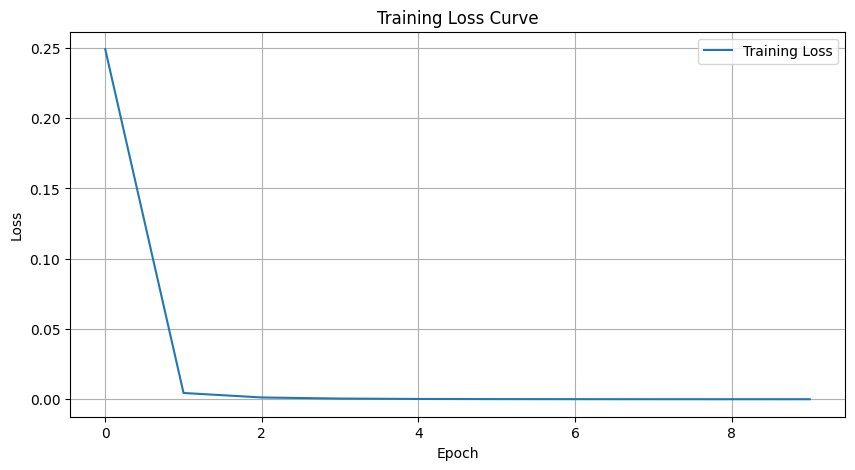

In [ ]:
# 1. Function to Plot Training Loss Curve
def plot_training_loss(train_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the training loss
plot_training_loss(train_losses)

In [12]:
generic_stmt_test_path = "generic_synatx_statment_test.dataset"

with open(generic_stmt_test_path, "rb") as f:
    test_generic_sqls = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = SQLDataset(test_generic_sqls, tokenizer)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model.eval()
test_loss = 0
with torch.no_grad():
    for input_seq, target_seq in dataloader:
        input_seq, target_seq = input_seq.to(device), target_seq.to(device)

        output = model(input_seq, input_seq)
        loss = criterion(output.view(-1, output.size(-1)), target_seq.view(-1))
        test_loss += loss.item()

average_test_loss = test_loss / len(dataloader)
print(f"Test Loss on {len(test_generic_sqls)} samples: {average_test_loss}")

Test Loss on 10000 samples: 1.1094030021887905e-06


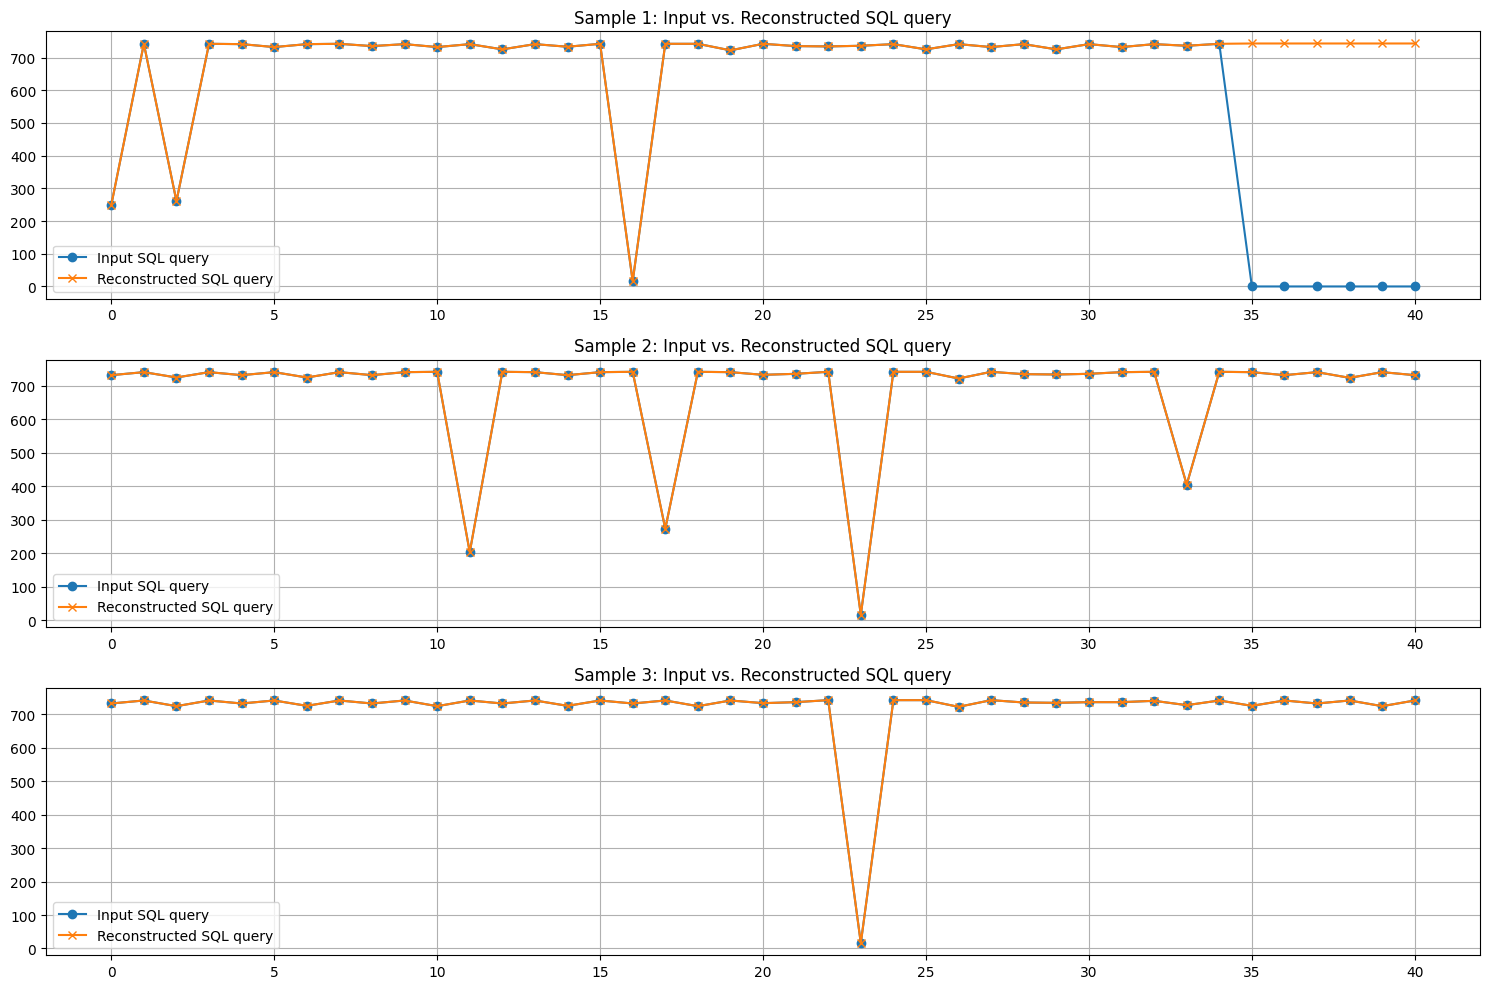

In [ ]:
# 2. Function to Plot Input vs. Output Sequence for Visualization
def plot_reconstructions(model, dataloader, device):
    model.eval()
    input_seq, target_seq = next(iter(dataloader))
    input_seq, target_seq = input_seq.to(device), target_seq.to(device)

    with torch.no_grad():
        output_seq = model(input_seq, input_seq).argmax(dim=-1)

    input_seq = input_seq.cpu().numpy()
    output_seq = output_seq.cpu().numpy()

    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    for i in range(3):
        axes[i].plot(input_seq[i], label='Input SQL query', marker='o')
        axes[i].plot(output_seq[i], label='Reconstructed SQL query', marker='x')
        axes[i].set_title(f'Sample {i + 1}: Input vs. Reconstructed SQL query')
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.savefig('reconstructed_sqls.png')
    plt.show()

# Plot input vs. output comparison
plot_reconstructions(model, dataloader, device)

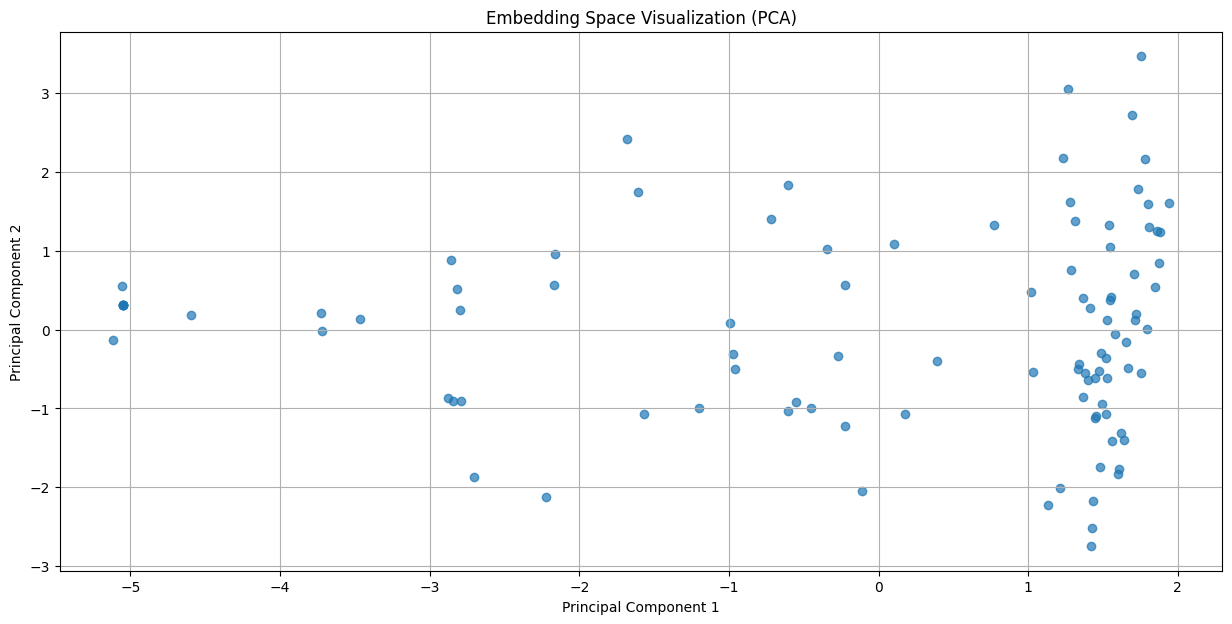

In [ ]:
# Optional: Visualizing Embedding Space using PCA
from sklearn.decomposition import PCA

def plot_embedding_space(model, dataloader, device, num_samples=100):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for input_seq, _ in dataloader:
            input_seq = input_seq.to(device)
            embeddings = model.embedding(input_seq).mean(dim=1).cpu().numpy()
            all_embeddings.append(embeddings)

    all_embeddings = np.concatenate(all_embeddings, axis=0)

    # Apply PCA to reduce dimensionality to 2D for visualization
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(all_embeddings[:num_samples])

    plt.figure(figsize=(15, 7))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7)
    plt.title('Embedding Space Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.savefig('embedding_space.png')
    plt.show()

plot_embedding_space(model, dataloader, device)